In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40

xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=2, dt=0.0001, Re=1.0)

simulation.update_bc_val(gridx, gridy, 'velc', scalars.var['to'])

In [3]:
simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')

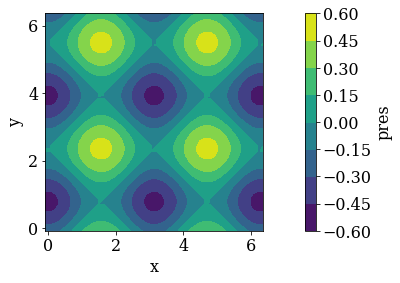

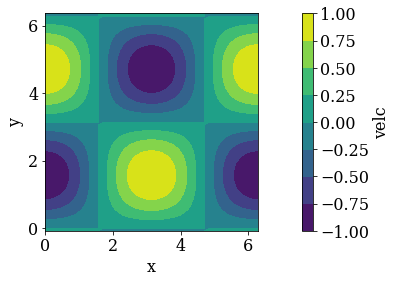

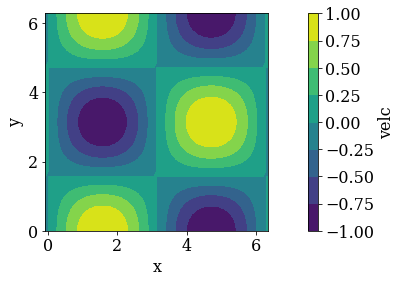

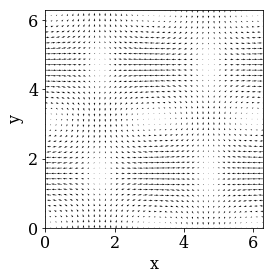

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx, gridy, 'velc')

In [5]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

while scalars.var['time'] <= scalars.var['tmax']:
    
    # Update the time-dependent boundary condition value
    simulation.update_bc_val(gridx, gridy, 'velc', scalars.var['time'])
    
    # Predictor Step
    flowx.ins.euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_jacobi(gridc, 'pres', 'divv',
                                                                       maxiter=10000, tol=1e-9)
    
    # Corrector Step
    flowx.ins.euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.var['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars.var['time'], scalars.stats)   
    
    scalars.advance()

------------ Time = 0.0 ---------------
Number of poisson iterations    : 7417
Final poisson residual : 9.995717326234806e-10
Max, Min, U   : 0.9969173337331281, -0.996917333733128
Max, Min, V   : 0.996917333733128, -0.9969173337331281
Max, Min, P   : 1.4734081003573198, -1.487992108021264
Max, Min, DIV : 2.2339775862523226e-11, -2.2339810556992745e-11


------------ Time = 0.0010000000000000002 ---------------
Number of poisson iterations    : 323
Final poisson residual : 9.88667769058647e-10
Max, Min, U   : 0.9949254915717706, -0.9949254915717705
Max, Min, V   : 0.9949254915717705, -0.9949254915717706
Max, Min, P   : 0.48899263940705806, -0.48915338810127507
Max, Min, DIV : 2.9006685942079002e-11, -3.113727678472067e-11


------------ Time = 0.0020000000000000005 ---------------
Number of poisson iterations    : 322
Final poisson residual : 9.82886414274254e-10
Max, Min, U   : 0.9929376291137059, -0.9929376291137058
Max, Min, V   : 0.9929376291137058, -0.9929376291137059
Max, Min, P 

------------ Time = 0.021999999999999922 ---------------
Number of poisson iterations    : 314
Final poisson residual : 9.980927676552177e-10
Max, Min, U   : 0.954003987789395, -0.9540039877893949
Max, Min, V   : 0.9540039877893949, -0.954003987789395
Max, Min, P   : 0.4496879807504236, -0.4498420431517924
Max, Min, DIV : 3.011035865085887e-11, -3.3385752495895815e-11


------------ Time = 0.022999999999999916 ---------------
Number of poisson iterations    : 314
Final poisson residual : 9.93828119344184e-10
Max, Min, U   : 0.9520978865504223, -0.9520978865504222
Max, Min, V   : 0.9520978865504222, -0.9520978865504223
Max, Min, P   : 0.44789591423560254, -0.44804900403452474
Max, Min, DIV : 2.9991009675711666e-11, -3.325959039429671e-11


------------ Time = 0.02399999999999991 ---------------
Number of poisson iterations    : 314
Final poisson residual : 9.896287435786236e-10
Max, Min, U   : 0.9501955937042652, -0.9501955937042651
Max, Min, V   : 0.9501955937042651, -0.950195593704265

------------ Time = 0.04400000000000023 ---------------
Number of poisson iterations    : 311
Final poisson residual : 9.815777292270496e-10
Max, Min, U   : 0.9129378915601292, -0.9129378915601291
Max, Min, V   : 0.9129378915601291, -0.9129378915601292
Max, Min, P   : 0.4118620104275225, -0.41199311565649616
Max, Min, DIV : 2.969635648497615e-11, -3.279858676319414e-11


------------ Time = 0.04500000000000026 ---------------
Number of poisson iterations    : 311
Final poisson residual : 9.77640663595154e-10
Max, Min, U   : 0.9111138404361498, -0.9111138404361497
Max, Min, V   : 0.9111138404361497, -0.9111138404361498
Max, Min, P   : 0.410220129388949, -0.41035021302616026
Max, Min, DIV : 2.957778466594618e-11, -3.266606343060863e-11


------------ Time = 0.04600000000000029 ---------------
Number of poisson iterations    : 310
Final poisson residual : 9.977558937374135e-10
Max, Min, U   : 0.909293433768747, -0.909293433768747
Max, Min, V   : 0.909293433768747, -0.909293433768747
Max, 

------------ Time = 0.06600000000000086 ---------------
Number of poisson iterations    : 307
Final poisson residual : 9.905789527330266e-10
Max, Min, U   : 0.8736876120712637, -0.8736876120712619
Max, Min, V   : 0.8736876120712611, -0.8736876120712643
Max, Min, P   : 0.3772110225143803, -0.37732157458254373
Max, Min, DIV : 3.0006774842661343e-11, -3.285583697471006e-11


------------ Time = 0.06700000000000089 ---------------
Number of poisson iterations    : 307
Final poisson residual : 9.865962452054886e-10
Max, Min, U   : 0.871945073731804, -0.8719450737318023
Max, Min, V   : 0.8719450737318015, -0.8719450737318047
Max, Min, P   : 0.3757070960658019, -0.375816816869929
Max, Min, DIV : 2.988698177830429e-11, -3.271942612681489e-11


------------ Time = 0.06800000000000092 ---------------
Number of poisson iterations    : 307
Final poisson residual : 9.82628950809789e-10
Max, Min, U   : 0.8702060096580103, -0.8702060096580085
Max, Min, V   : 0.870206009658008, -0.8702060096580112
Max

KeyboardInterrupt: 

In [6]:
simulation.get_analytical(gridc, gridx, gridy, 'asol', scalars.var['time'])

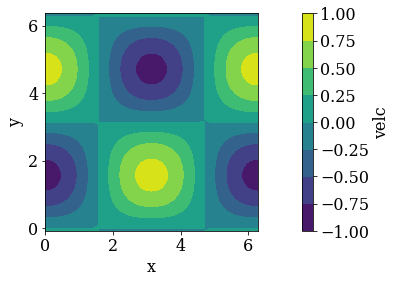

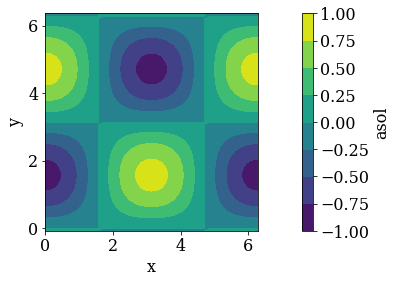

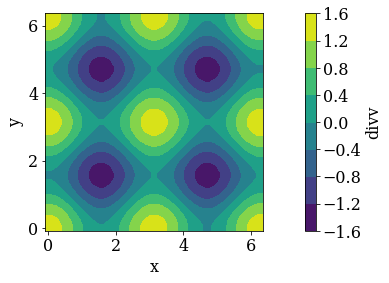

In [7]:
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridx, 'asol')
flowx.io.plot_contour(gridc, 'divv')

In [8]:
gridx.get_error('eror','velc','asol')
gridy.get_error('eror','velc','asol')

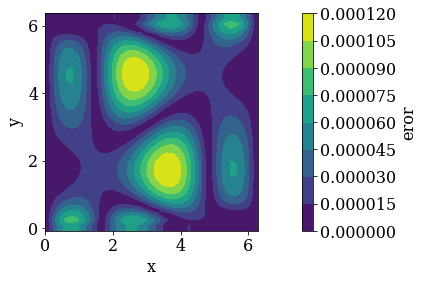

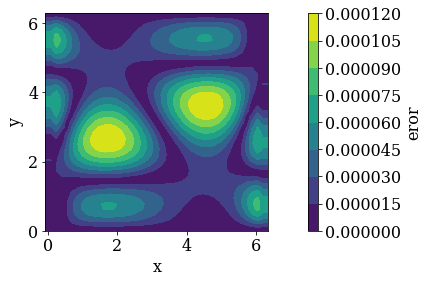

In [9]:
flowx.io.plot_contour(gridx, 'eror')
flowx.io.plot_contour(gridy, 'eror')